# KNN vs ANN - Regression
## Evaluating and comparing the performance of each model

### Part 1 : Acquiring data / EDA

For the regression comparison of both models, I chose the California housing dataset from sklearn. 

In [4]:
#from sklearn.datasets import fetch_california_housing

#housing = fetch_california_housing()
#df = pd.DataFrame(housing.data, columns=housing.feature_names)
#df['target'] = housing.target
#df.to_csv('california.csv')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('california.csv')

In [6]:
df.head()

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The California housing datasets has 8 features.
- MedInc        : median income in block group
- HouseAge      : median house age in block group
- AveRooms      : average number of rooms per household
- AveBedrms     : average number of bedrooms per household
- Population    : block group population
- AveOccup      : average number of household members
- Latitude      : block group latitude
- Longitude     : block group longitude

I dropped the first column, which represents rows.

In [8]:
print(df['Unnamed: 0'].value_counts)
df = df.drop('Unnamed: 0', axis=1)

<bound method IndexOpsMixin.value_counts of 0            0
1            1
2            2
3            3
4            4
         ...  
20635    20635
20636    20636
20637    20637
20638    20638
20639    20639
Name: Unnamed: 0, Length: 20640, dtype: int64>


Also checked for any missing values, but all values were present.

In [10]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

<Axes: >

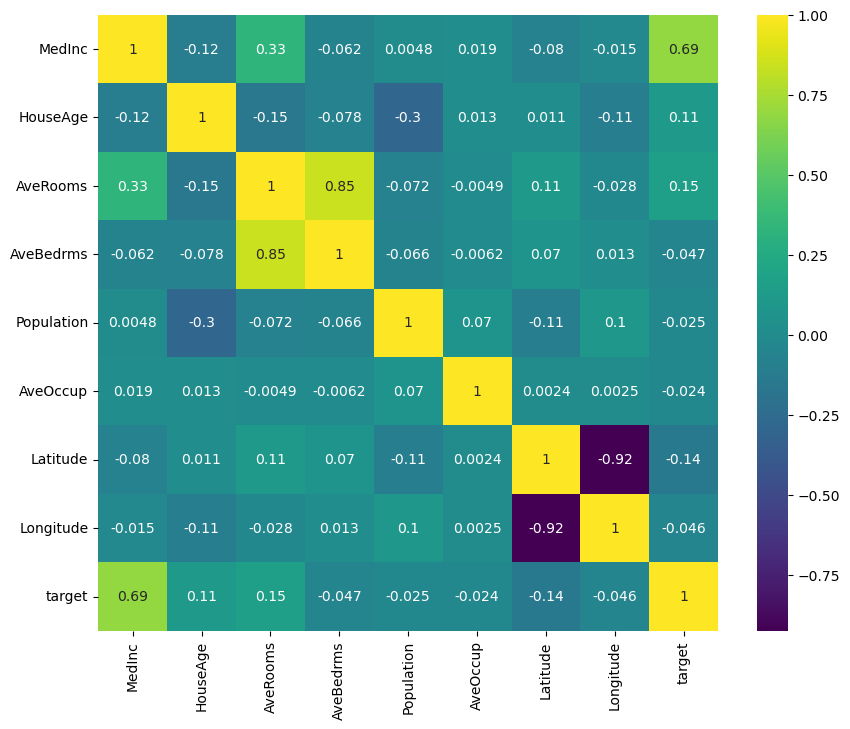

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

The heatmap shows us two high correlated features : 
* target(the median house price) vs MedInc
* AveRooms vs AveBedrms

AveRooms vs AveBedrms seems natural to be highly correlated because the more rooms you have, the more bathrooms the house will have. Also, it is normal for people with higher income buying higher priced houses.  

<Axes: xlabel='target', ylabel='MedInc'>

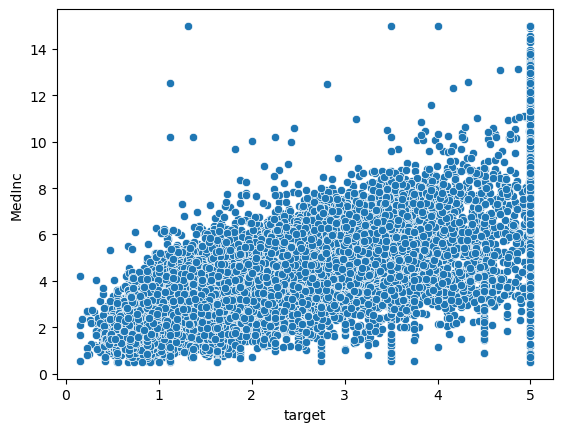

In [13]:
sns.scatterplot(data=df, x='target', y='MedInc')

#### Scatter Plot (target vs Median Income)
According to the scatter plot above, it seems like to show a linear shape which makes sense, except for the straight line where target=5.
What is interesting here is that people with any amount of income purchased the most expensive houses, so I had to find out more about the data where target = 5.

<Figure size 1200x600 with 0 Axes>

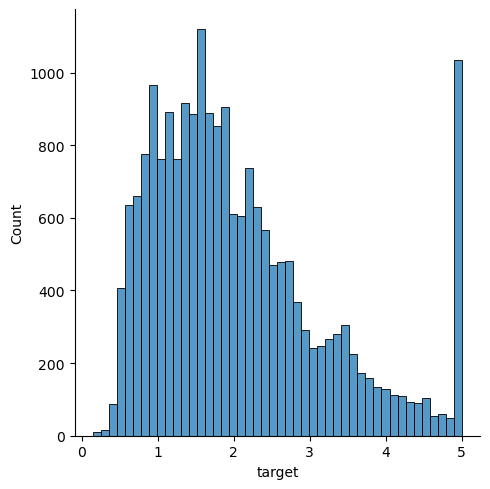

In [15]:
plt.figure(figsize=(12,6))
sns.displot(df, x='target')

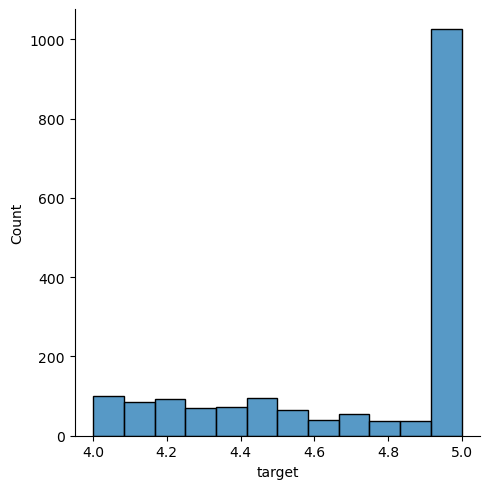

In [16]:
df_expensive = df[df['target'] >= 4.0]
sns.displot(df_expensive, x='target')

#### Distribution of the target (Med Housing Prices) : 
We can see that most prices are in between 100~300K dollars. Also, we can check a significant peak at 500K, which are the expensive houses. I wanted to see what areas are considered expensive, since we already have the latitude and the longtitude.

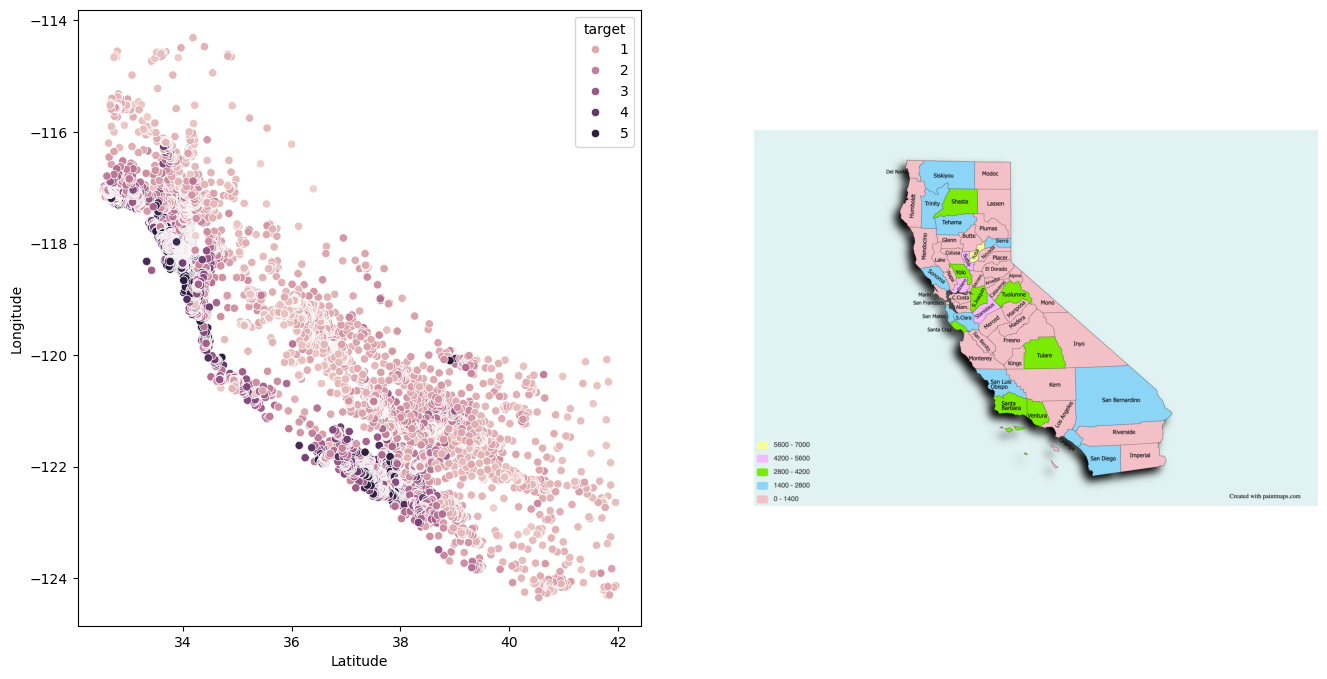

In [18]:
from PIL import Image
img = Image.open('california_map.png')
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data=df, ax=axes[0],  x='Latitude', y='Longitude', hue='target')
axes[1].imshow(img)
axes[1].axis('off')

plt.show()


#### Interpretation of the target data : 
Finally, I checked the prices of the houses, and most of the expensive (target >= 5.0) houses were located near the coast. Also, most of them were packed in some cities known to be expensive, such as Los Angeles and San Francisco. <br/>
I assumed that regardless of the income, most houses in these cities priced over 500K and this is why we have such an imbalanced graph.
I also thought that this might affect the performance of our models. 


<Axes: xlabel='target', ylabel='Population'>

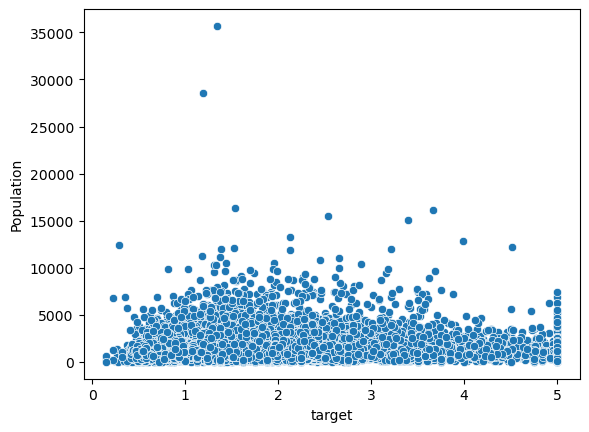

In [20]:
sns.scatterplot(data=df, x='target', y='Population')

Additionally, I thought that 'Population' would have a high correlance with our target housing price, but it seems like they do not and the data is evenly distributed.

### Part 2 : Training with K Nearest Neighbors

First, I split my data with 20% for testing and 80% for training. Then, I used the MinMaxScaler to scale my data.

In [23]:
X = df.drop('target', axis=1)
y = df['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
y_train.shape

(16512,)

First, I tried with the K value of 5 to see how my model would do. 

In [26]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)
predicted_knn = knn.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE : ", mean_squared_error(y_test, predicted_knn))
print("MAE : ", mean_absolute_error(y_test, predicted_knn))

MSE :  0.4001469959793682
MAE :  0.42665782267441854


The mean squared error and the mean absolute error were about 0.4, which means that the predicted price had about -40K ~ 40K difference with the actual prices. According to our EDA, we found out that most houses were priced 100K~300K and +500K. In this case, I think the model did not perform well since the error rate was about 20% of the actual prices. <br/>
Below is a scatterplot of predicted prices, where the red line represents the actual prices.

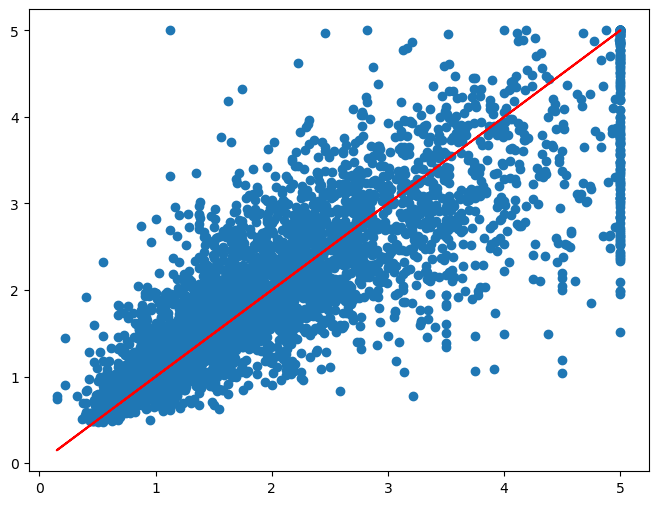

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, predicted_knn)
plt.plot(y_test, y_test, 'r') #Actual Prices

Now, I changed the K values from 1 ~ 20 to see how it would perform according to the K values.

The best performance was MSE = 0.3861001389811546  with k = 8


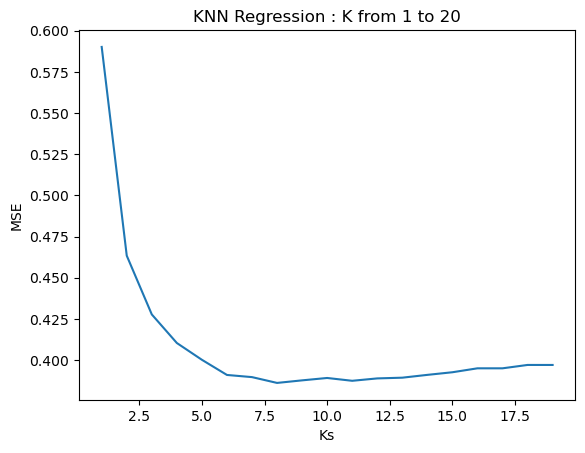

In [31]:
Ks = 20
mean_acc = np.zeros(Ks-1)

for i in range(1, Ks):
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train, y_train)
    yhat = knn.predict(X_test)
    mean_acc[i-1] = mean_squared_error(y_test, yhat)

plt.plot(range(1, Ks), mean_acc)
plt.ylabel("MSE")
plt.xlabel("Ks")
plt.title("KNN Regression : K from 1 to 20")


print( "The best performance was MSE =", mean_acc.min(), " with k =", mean_acc.argmin()+1)

Iterating from k = 1 to 20, the lowest error rate was at k=8, and started to increase after bigger values.


### Part 3 : Training with ANN 



In [34]:
#redefine X,y to retrieve numpy array
X = df.drop('target', axis=1).values
y = df['target'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)

(16512, 8) (16512,)


For the ANN, I chose to put 8 neurons for the input layer, 4 and 2 for the hidden layers, and 1 for the output layer.
Also, I chose ADAM for my optimizer and MSE for the loss, to match with the KNN above.

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

model.add(Dense(8, activation='relu')) #input layer
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))

model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mse')

In [37]:
epchs = 150
model.fit(x=X_train, y=y_train, batch_size=128, epochs=epchs)

Epoch 1/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 5.5767 
Epoch 2/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 4.9756
Epoch 3/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 4.6014
Epoch 4/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 3.9932
Epoch 5/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 2.8552
Epoch 6/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 1.9902
Epoch 7/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 1.5538
Epoch 8/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 1.4099
Epoch 9/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 1.2407
Epoch 10/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.9560
Epoch 11/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.8101
Epoch 12/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.7022
Epoch 13/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.6589
Epoch 14/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.6005
Epoch 15/150
1

In [38]:
predicted_ann = model.predict(X_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


<Axes: >

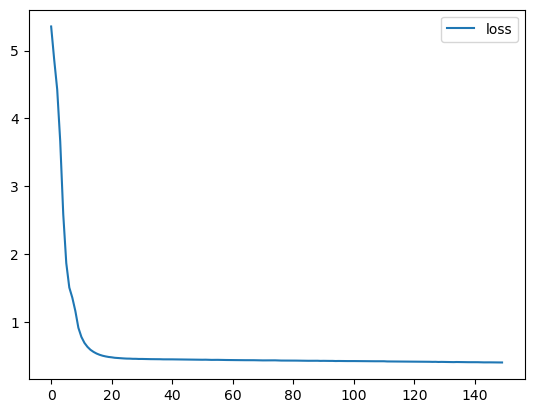

In [39]:
losses = pd.DataFrame(model.history.history)
losses.plot()

We can see that the loss(MSE) dropped quickly for the first 30 epochs, but the change slows after.

### Part 4 : Evaluation and Comparison of the two models

Minimum Loss : KNN =  0.3861001389811546 ANN =  loss    0.402173
dtype: float64


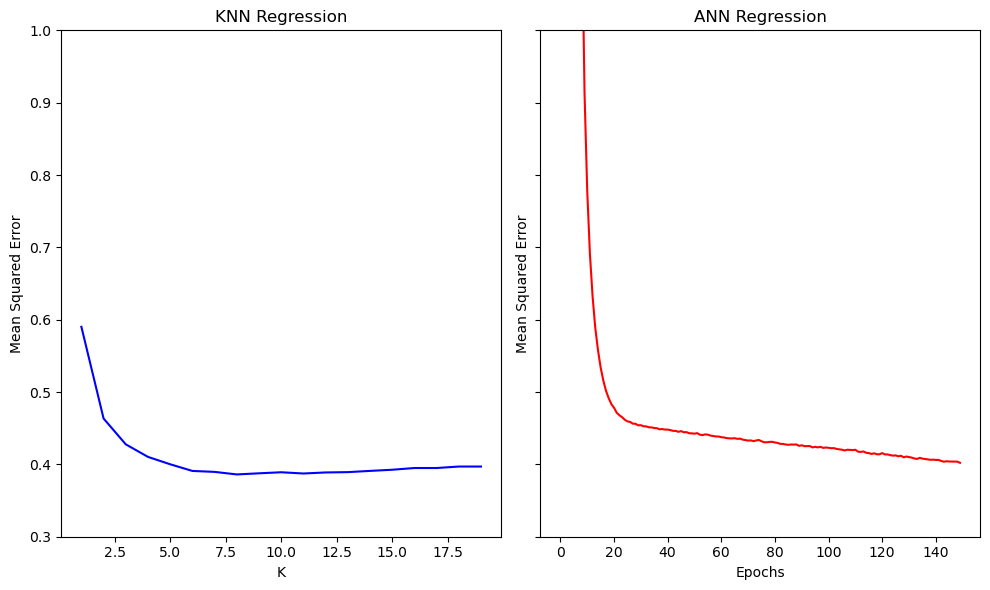

In [42]:
fig, axes = plt.subplots(1,2, figsize=(10,6), sharey='row')

axes[0].plot(range(1, Ks), mean_acc, color='blue')
axes[0].set_title('KNN Regression')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_ylim(0.3,1)

axes[1].plot(range(0,epchs), losses, color='red')
axes[1].set_title('ANN Regression')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
print("Minimum Loss : KNN = ", mean_acc.min(), "ANN = ", losses.min())

### Part 5 : Dropping skewed data and re-training models

I wanted to see how the model would perform without the skewed data. There were too many houses that had a target label above or equal to 5, which I think influenced the model's performance.

In [44]:
df_cheap = df[df['target'] < 5.0]

<Axes: xlabel='target', ylabel='MedInc'>

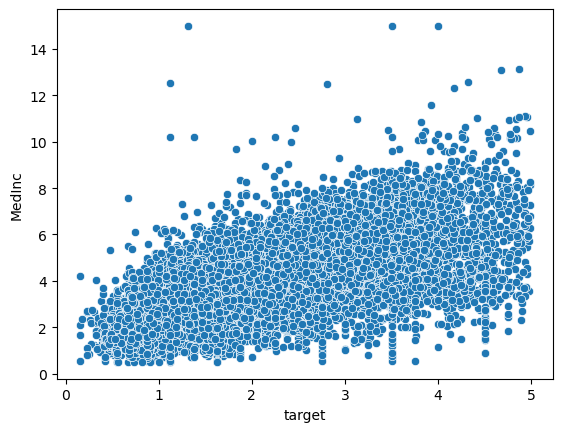

In [45]:
sns.scatterplot(data=df_cheap, x='target', y='MedInc')

The best performance was MSE = 0.3071389468936577  with k = 8


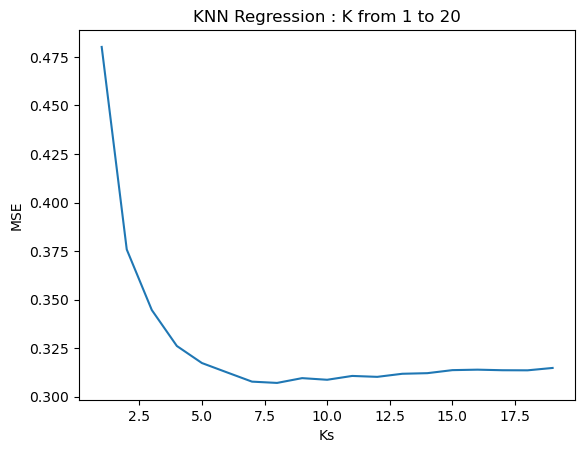

In [46]:
X = df_cheap.drop('target', axis=1)
y = df_cheap['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Ks = 20
mean_acc = np.zeros(Ks-1)

for i in range(1, Ks):
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train, y_train)
    yhat = knn.predict(X_test)
    mean_acc[i-1] = mean_squared_error(y_test, yhat)

plt.plot(range(1, Ks), mean_acc)
plt.ylabel("MSE")
plt.xlabel("Ks")
plt.title("KNN Regression : K from 1 to 20")


print( "The best performance was MSE =", mean_acc.min(), " with k =", mean_acc.argmin()+1)

Training without the expensive (target >= 5.0) houses, the KNN model performed best at k=8 with MSE = 0.307, slightly better than the previous model.

In [47]:
X = df_cheap.drop('target', axis=1).values
y = df_cheap['target'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(8, activation='relu')) #input layer
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))

model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mse')

epchs = 150
model.fit(x=X_train, y=y_train, batch_size=128, epochs=epchs)

Epoch 1/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 4.6408 
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 4.1065
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 3.6631
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 3.3344
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 2.9417
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 2.6750
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 2.4055
Epoch 8/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 2.2290
Epoch 9/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 1.9671
Epoch 10/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 1.8192
Epoch 11/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 1.7174
Epoch 12/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 1.5517
Epoch 13/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 1.4355
Epoch 14/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 1.3228
Epoch 15/150
1

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


<Axes: >

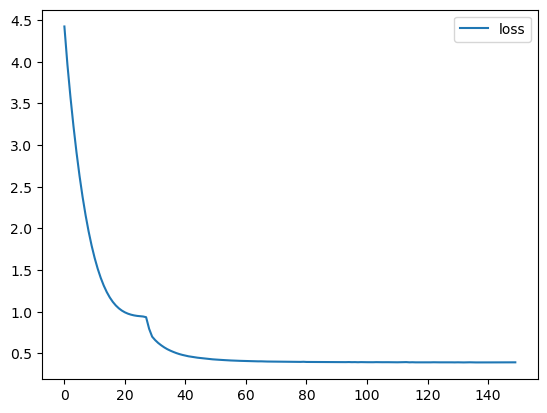

In [48]:
predicted_ann = model.predict(X_test)
losses = pd.DataFrame(model.history.history)
losses.plot()

Minimum Loss : KNN =  0.3071389468936577 ANN =  loss    0.391942
dtype: float64


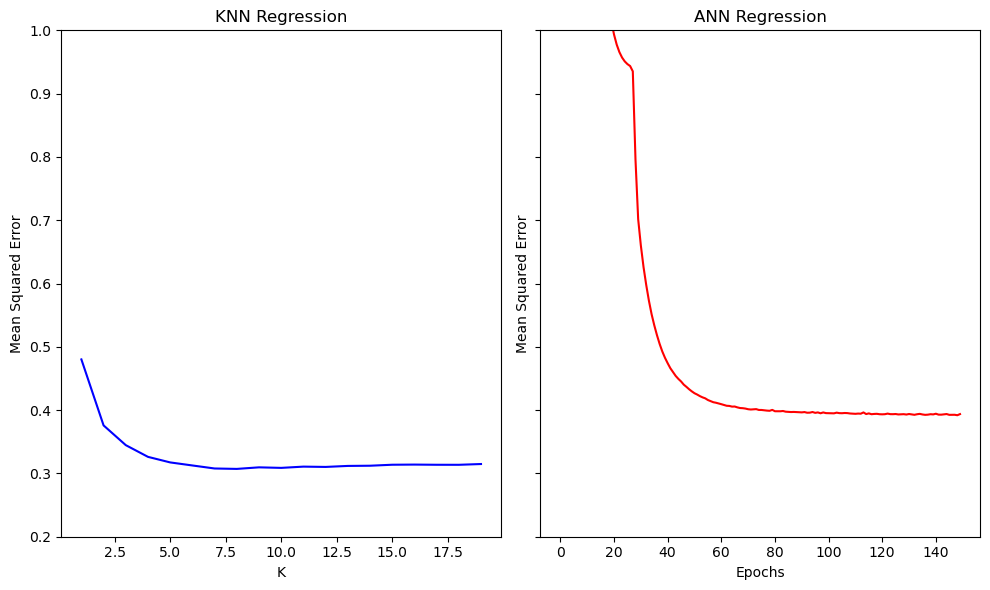

In [49]:
fig, axes = plt.subplots(1,2, figsize=(10,6), sharey='row')

axes[0].plot(range(1, Ks), mean_acc, color='blue')
axes[0].set_title('KNN Regression')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_ylim(0.2,1)

axes[1].plot(range(0,epchs), losses, color='red')
axes[1].set_title('ANN Regression')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
print("Minimum Loss : KNN = ", mean_acc.min(), "ANN = ", losses.min())

Without the expensive houses, both models did pretty similar to its previous models. <br/>
In general, KNN performed slightly better than the ANN model.

### Conclusion

In conclusion, both models have shown similar performances (KNN slightly better) on regression tasks. However, modifications to the ANN model such as dropout layers might improve the performance. 